Author: Pierce Rotman

Instructor: Pashaie

Course: CAP 6673

Date: 17 October 2023


1. First, we load and plot the data

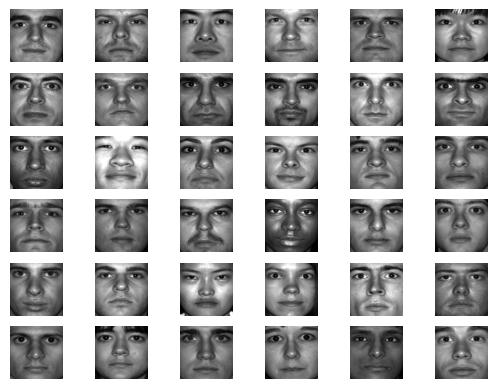

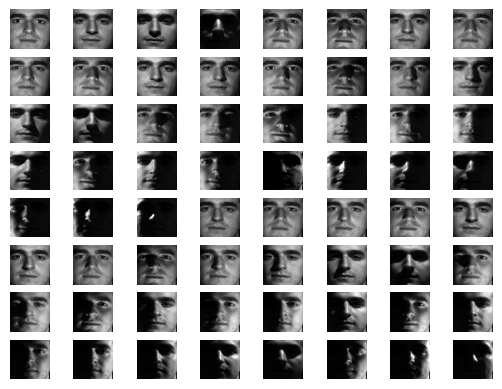

In [70]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
faces = scipy.io.loadmat("/Users/piercerotman/Documents/"+
                         "MastersProgram/Machine_Learning/allFaces.mat")

nfaces = np.array(faces['nfaces'])
faces = np.array(faces['faces'])
n = 192
m=168



person = np.zeros((n,m,36))
plt.figure(1)
for i in range(36):
    person[:, :, i] = faces[:, sum(nfaces[0,0:i-1])].reshape(m,n).transpose()
    plt.subplot(6,6,i+1)
    plt.imshow(person[:,:,i], cmap = 'gray')
    plt.axis('off')
    plt.gca().set_aspect(0.8802, adjustable = 'box')

plt.show()

snapshot = np.zeros((n,m,64))
for i in range(len(nfaces[0,:])):
    subset = faces[:,sum(nfaces[0,0:i]):sum(nfaces[0,0:i+1])]
    for j in range(nfaces[0,i]):
        snapshot[:,:,j] = subset[:,j].reshape(m,n).transpose()

plt.figure(1)
for i in range(64):
    plt.subplot(8,8, i+1)
    plt.imshow(snapshot[:,:,i], cmap = 'gray')
    plt.axis('off')
    plt.gca().set_aspect(0.8802, adjustable = 'box')
plt.show()


2. Next, we get the average face and generate the matrix X.

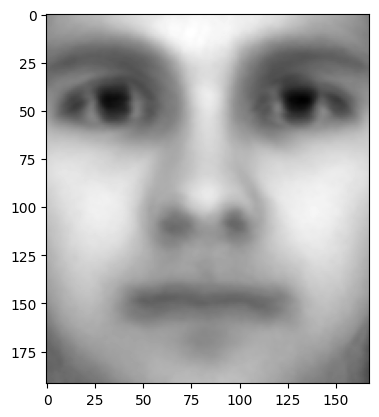

In [3]:
average_face = np.sum(faces[:, 0:sum(nfaces[0,0:36])], axis=1) / sum(nfaces[0,0:36])
plt.figure(1)
plt.imshow(average_face.reshape(168,192).T, cmap = 'gray')
plt.show()
X = np.array([faces[:,i]-average_face for i in range(sum(nfaces[0,0:36]))])

3. Now, we calculate the singular values and singular vectors of X and plot the first 54 eigen faces.

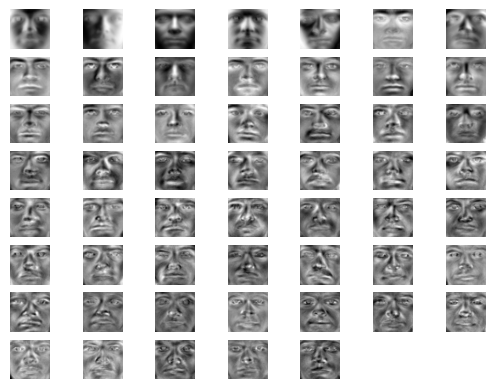

In [4]:
U, S, V = np.linalg.svd(X.transpose(), full_matrices=False)
plt.figure(1)
for i in range(54):
    plt.subplot(8,7, i+1)
    plt.imshow(U[:,i].reshape(168,192).T, cmap = 'gray')
    plt.axis('off')
    plt.gca().set_aspect(0.8802, adjustable = 'box')
plt.show()

We know that each of these faces is orthogonal to every other face. We check this below with two pairs of faces. It is clear that these faces are trying to detect different features. For example, the 6th eigen face is very obviously focused on the area around the eye-socket, while the 10th seems to focus on detecting the nose. 

In [5]:
firstfifth = U[:,0].dot(U[:,4].transpose())
print(firstfifth)

tenthfifteenth = U[:,9].dot(U[:,14].transpose())
print(tenthfifteenth)

-6.055536954678745e-16
-6.815996881624352e-16


4. We now decompose the 1st image of person 37 to its eigen faces, first using 

Number of eigenfaces: 5


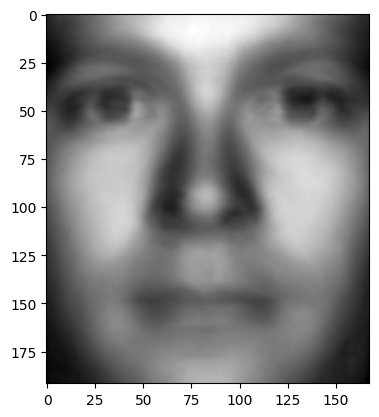

Number of eigenfaces: 10


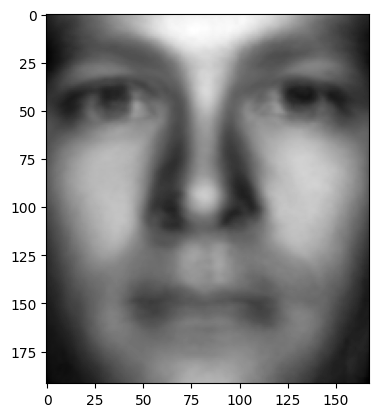

Number of eigenfaces: 200


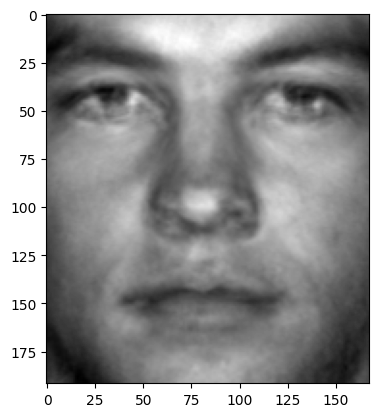

Number of eigenfaces: 800


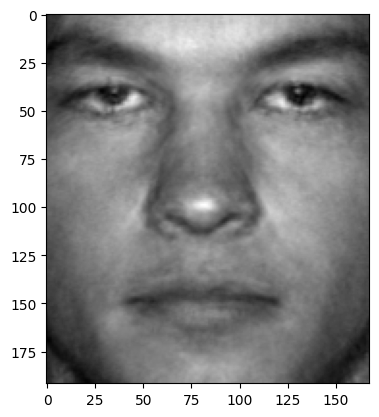

Number of eigenfaces: 100


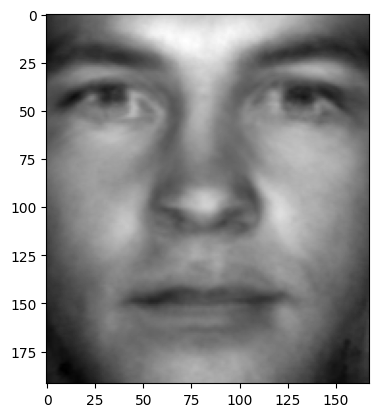

In [6]:
p37 = faces[:,sum(nfaces[0, 0:36])]

rs = [5, 10, 200, 800, 100]
for r in rs:
    print(f"Number of eigenfaces: {r}")
    V = np.zeros(32256)
    for i in range(r):
        V += U[:,i].transpose().dot(p37)*(U[:,i])
    
    plt.figure(1)
    plt.imshow(V.reshape(168,192).T, cmap = 'gray')
    plt.show()


The maximum value of r is the number of eigenvectors: 2282. We see that 5 eigenfaces is not enough to get any sort of clear picture, but it is certainly enough to see that this image is a human face. 10 eigenfaces is likewise lacking any detail, but 200 eigenfaces allows us to potentially recognize this person, and certainly to distinguish him from other individuals. 800 eigenfaces gives us an extremely good approximation of his face, but does not save much memory. 

100 eigenfaces is a fairly good approximation of this individual's face. It clearly identifies some features, and would absolutely permit us to distinguish him from other people.

5. Now, we plot the singular values.

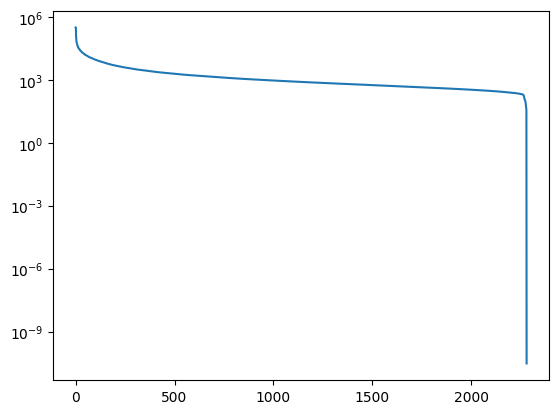

In [7]:
plt.figure(1)
plt.plot(S)
plt.semilogy()
plt.show()

I see two good points for truncation: 20 eigenfaces and 2200 eigenfaces. The most important eigenfaces are before ~20 on the x-axis, and with these we can likely get a good approximation. However, the values between this and ~2200 are still relatively important, and without them, a lot of smaller details will be lost. However, for the sake of identification, ~20 seems a good place for truncation.

6. First we calculate the amount of eigenface 5 and 6 in both person 2 and person 7. 

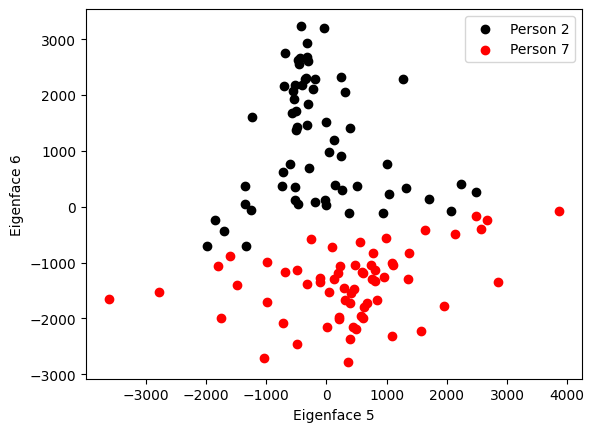

In [8]:
p2 = faces[:, sum(nfaces[0,0:1]): sum(nfaces[0,0:2])]
p7 = faces[:, sum(nfaces[0,0:6]): sum(nfaces[0,0:7])]

p2e5 = []
for i in range(62):
    p2e5.append(p2[:,i].transpose().dot(U[:,4]))
p2e6 = []
for i in range(62):
    p2e6.append(p2[:,i].transpose().dot(U[:,5]))

p7e5 = []
for i in range(64):
    p7e5.append(p7[:,i].transpose().dot(U[:,4]))
p7e6 = []
for i in range(64):
    p7e6.append(p7[:,i].transpose().dot(U[:,5]))

x1 = p2e5 + p7e5
x2 = p2e6 + p7e6
X = np.array([x1, x2]).transpose()

plt.scatter(x=X[:62,0], y=X[:62,1], color = 'black', label = 'Person 2')
plt.scatter(x=X[62:,0], y=X[62:,1], color = 'red', label = 'Person 7')
plt.xlabel('Eigenface 5')
plt.ylabel('Eigenface 6')
plt.legend()
plt.show()

We can clearly see that these faces have similar amounts of eigenface 5, but that person 2 has much more of eigenface 6 than person 7. This should allow us to classify these images.

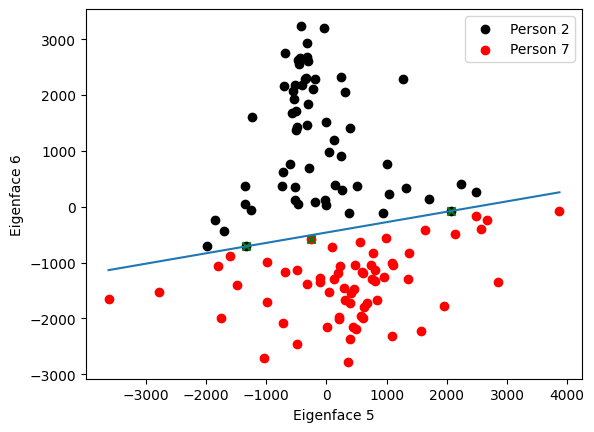

In [60]:
import seaborn as sns
d = [-1 for i in range(62)] + [1 for i in range(64)]
Y = np.array([d]).transpose()

m = X[:,0].size
midm = int(m/2)
n = X[1,:].size

def poly(x1, x2, order):
    """
    Calculates polynomial kernel for two vectors of X, given order
    Args:
        x1 (numpy.ndarray): value1
        x2 (numpy.ndarray): value2
        order (int): order of polynomial
    Returns:
        (float) poly of x1, x2
    """
    return (1 - np.dot(x1, x2)) ** order



#Create variable and Q matrix
alphas = np.zeros(126)
ones = np.ones(126)
Q = np.zeros((126,126))
for i in range(126):
    for j in range(126):
        Q[i,j] = Y[i,:]*Y[j,:]*poly(X[i,:],X[j,:], 1)



#Make KKT conditions
constraints = {'type': 'eq', 'fun': lambda alphas: Y.transpose().dot(alphas)}
def function(alphas):
    return -0.005 * alphas.transpose().dot(Q).dot(alphas) - ones.transpose().dot(alphas)



minimization = scipy.optimize.minimize(function, alphas, constraints = constraints, bounds = [(0, 1) for i in range(m)])
optimized_alphas = minimization.x
sv_indices = np.where(optimized_alphas > 0.001)[0]

#find b:
def decision_boundary(x):
    """
    Calculates decision function
    Args:
        x (numpy.ndarray): value to calculate decision function for
    Returns:
        (float) decision function value
    """
    return sum([optimized_alphas[i] * Y[i,:][0] * poly(X[i,:], x, 1) for i in sv_indices])


W = np.zeros((2,1))
for i in sv_indices:
    W[0] += optimized_alphas[i] * Y.flatten()[i] * X[i,0]
    W[1] += optimized_alphas[i] * Y.flatten()[i] * X[i,1]

b = 1 - decision_boundary(X[sv_indices[1],:])
fig, ax = plt.subplots()
plt.scatter(x=X[:62,0], y=X[:62,1], color = 'black', label = 'Person 2')
plt.scatter(x=X[62:,0], y=X[62:,1], color = 'red', label = 'Person 7')
plt.xlabel('Eigenface 5')
plt.ylabel('Eigenface 6')
plt.scatter(x=X[23,0], y=X[23,1], color='green', marker = 'x')
plt.scatter(x=X[47,0], y=X[47,1], color='green', marker = 'x')
plt.scatter(x=X[125,0], y=X[125,1], color='green', marker = 'x')
plt.legend()
sns.lineplot(x = X[:,0], y = -(W[0]*X[:,0]-b)/W[1])
plt.show()

We are able to separate the data fairly well with an SVM using a linear polynomial kernel. This indicates that we could likely use this PCA, combined with an SVM to perform facial recognition. Let's also take a look at the images right on the line (the support vectors).

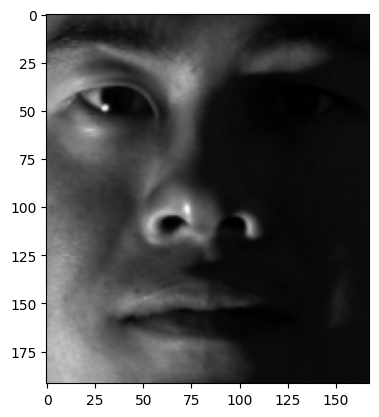

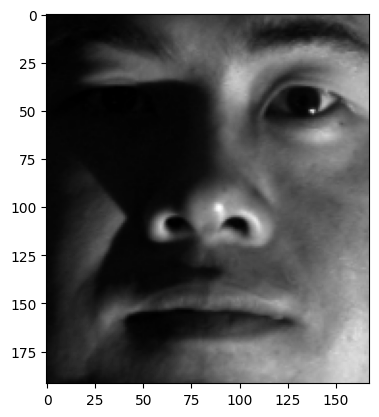

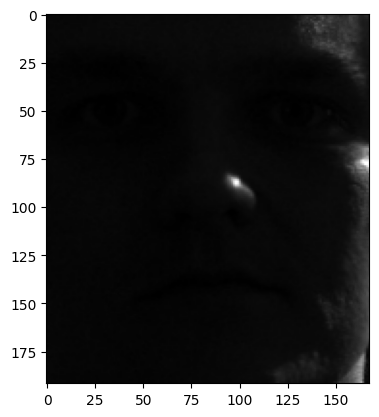

In [65]:
plt.figure(1)
plt.imshow(p2[:,23].reshape(168,192).T, cmap = 'gray')
plt.show()

plt.figure(1)
plt.imshow(p2[:,47].reshape(168,192).T, cmap = 'gray')
plt.show()

plt.figure(1)
plt.imshow(p7[:,63].reshape(168,192).T, cmap = 'gray')
plt.show()


It makes quite a bit of sense that these images would be difficult to classify, as they are very dark and missing a lot of features, especially the last image. The images which are clear and show the entire face are very easy to classify, and our SVM would have no trouble differentiating between them. Even so, the SVM correctly identifies these photos.